This notebook contains the code to determine the minimum Explained Deviation (ED) based on the AAMI/ANSI/ISO Standards. To do this, we subsample the [PPG-BP dataset](https://figshare.com/articles/dataset/PPG-BP_Database_zip/5459299) based on weights derived from iterative proportional fitting.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from ipfn import ipfn

In [3]:
data = pd.read_excel('../datasets/PPG-BP/PPG-BP dataset.xlsx', header=1)

In [4]:
subj_ids = data['subject_ID'].values
SBP = data['Systolic Blood Pressure(mmHg)'].values
DBP = data['Diastolic Blood Pressure(mmHg)'].values
SBP_bounds = [SBP <= 100, (SBP > 100) & (SBP < 140), (SBP >= 140) & (SBP < 160), SBP >= 160]
DBP_bounds = [DBP <= 60, (DBP > 60) & (DBP < 85), (DBP >= 85) & (DBP < 100), DBP >= 100]
bound_marginals = [0.1, 0.6, 0.2, 0.1]

In [5]:
sbp_stds = []
dbp_stds = []

for iter in range(10000):  
    results_grid_bounds = np.zeros((len(SBP_bounds), len(SBP_bounds)))
    for i in range(len(SBP_bounds)):
        for j in range(len(DBP_bounds)):
            results_grid_bounds[i, j] = np.sum(SBP_bounds[i] & DBP_bounds[j])
#     pd.DataFrame(results_grid_bounds/np.sum(results_grid_bounds), 
#                  columns=['SBP <= 100', '(SBP > 100) & (SBP < 140)', '(SBP >= 140) & (SBP < 160)', 'SBP >= 160'], 
#                  index=['DBP <= 60', '(DBP > 60) & (DBP < 85)', '(DBP >= 85) & (DBP < 100)', 'DBP >= 100'])

    IPF = ipfn.ipfn(results_grid_bounds, [bound_marginals, bound_marginals], [[0], [1]])
    m = IPF.iteration()
    pd.DataFrame(m, 
                 columns=['SBP <= 100', '(SBP > 100) & (SBP < 140)', '(SBP >= 140) & (SBP < 160)', 'SBP >= 160'], 
                 index=['DBP <= 60', '(DBP > 60) & (DBP < 85)', '(DBP >= 85) & (DBP < 100)', 'DBP >= 100'])

    pr = np.zeros((len(SBP),))
    for i in range(len(SBP_bounds)):
        for j in range(len(DBP_bounds)):
            if np.sum(SBP_bounds[i] & DBP_bounds[j]) > 0:
                pr += m[i, j]*(SBP_bounds[i] & DBP_bounds[j])/np.sum(SBP_bounds[i] & DBP_bounds[j])
    samples = np.random.choice(np.arange(0, len(data)), size=(85,), replace=False, p=pr)


    SBP_samp = SBP[samples]
    DBP_samp = DBP[samples]
    SBP_conds = [SBP_samp <= 100, SBP_samp >= 160, SBP_samp >= 140]
    DBP_conds = [DBP_samp <= 60, DBP_samp >= 100, DBP_samp >= 85]
    marginals = [0.05, 0.05, 0.2]

    results_grid = np.zeros((len(SBP_conds), len(SBP_conds)))
    for i in range(len(SBP_conds)):
        for j in range(len(DBP_conds)):
            results_grid[i, j] = np.sum(SBP_conds[i] & DBP_conds[j])
#     pd.DataFrame(results_grid/len(SBP_samp),
#                  columns=['SBP <= 100', 'SBP >= 160' , 'SBP >= 140'], 
#                  index=['DBP <= 60', 'DBP >= 100', 'DBP >= 85'])

    if (np.sum(results_grid/len(SBP_samp), axis=0) > marginals).all() & (np.sum(results_grid/len(SBP_samp), axis=1) > marginals).all():
        sbp_stds.append(SBP_samp.std())
        dbp_stds.append(DBP_samp.std())

Text(0, 0.5, 'Count')

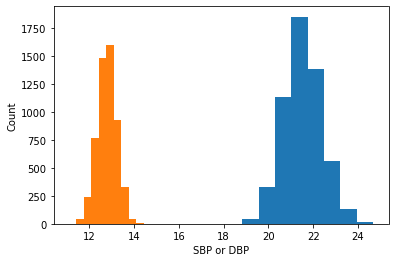

In [6]:
plt.hist(sbp_stds, label='SBP STD')
plt.hist(dbp_stds, label='DBP STD')
plt.xlabel('SBP or DBP')
plt.ylabel('Count')

In [7]:
np.min(sbp_stds)/8, np.min(dbp_stds)/8

(2.1706071655479318, 1.3865892534508795)